In [5]:
# Importing Library

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Creating a simple dataset
data = {
    "Age": [22, 25, 47, 52, 46, 56],
    "Income": [15000, 30000, 50000, 45000, 60000, 80000],
    "Buys": [0, 1, 1, 0, 1, 0]  # Target (0 = No, 1 = Yes)
}

df = pd.DataFrame(data)

# Features and Target
X = df.drop("Buys", axis=1)
y = df["Buys"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Accuracy
print("Accuracy:", model.score(X_test, y_test))




Accuracy: 0.5


In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Result
print("Accuracy:", model.score(X_test, y_test))


Accuracy: 1.0


Data source: iris
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target classes: [0 1 2]
Best params: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_split': 2}
Test Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
5-fold CV accuracy: mean=0.9533, std=0.0340
Saved trained model to decision_tree_model.joblib
Saved tree plot to decision_tree_plot.png
Done


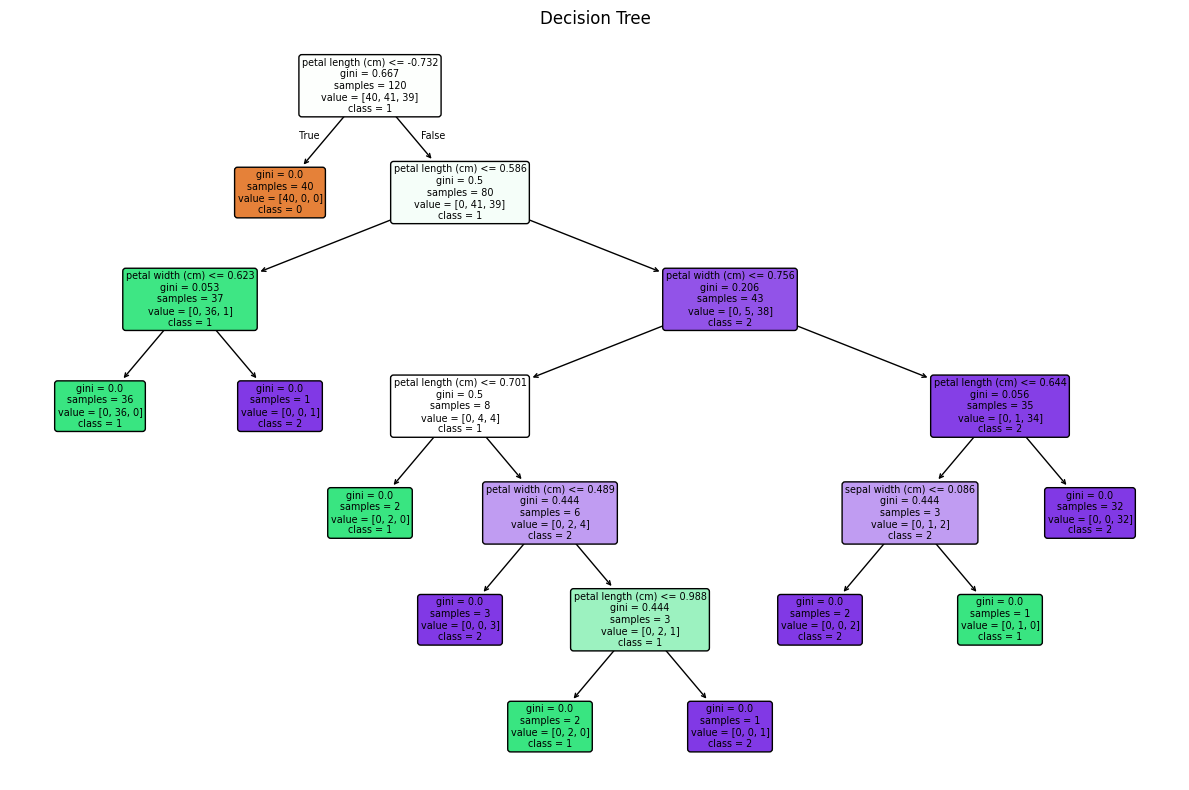

In [7]:
"""
Decision Tree model script
Options: use_iris, use_dummy, or provide a small custom dataset (in code)

Usage:
- Edit the variable `DATA_SOURCE` to one of: 'iris', 'dummy', 'custom'
- Run the script: python decision_tree_model.py

This script does:
- loads data (no CSV required)
- basic preprocessing (scaling, categorical encoding if needed)
- train/test split
- trains DecisionTreeClassifier
- evaluates (accuracy, classification report, confusion matrix, cross-val)
- optional GridSearchCV hyperparameter tuning
- saves trained model to disk (joblib)
- plots & saves the tree diagram (matplotlib)

"""

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_iris

# ------------------------
# USER CONFIG
# ------------------------
# Choose data source: 'iris', 'dummy', or 'custom'
DATA_SOURCE = 'iris'

# If 'custom', define the `custom_df` (pandas DataFrame) and `target_column` below
custom_df = pd.DataFrame({
    "Age": [22, 25, 47, 52, 46, 56],
    "Income": [15000, 30000, 50000, 45000, 60000, 80000],
    "Buys": [0, 1, 1, 0, 1, 0]
})
target_column = 'Buys'

# Model & training settings
TEST_SIZE = 0.2
RANDOM_STATE = 42
PERFORM_GRID_SEARCH = True

# Grid search parameter grid (only used if PERFORM_GRID_SEARCH=True)
PARAM_GRID = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 3, 5, 7],
    'model__min_samples_split': [2, 4, 6]
}

# Output filenames
MODEL_OUT = 'decision_tree_model.joblib'
TREE_PLOT_OUT = 'decision_tree_plot.png'

# ------------------------
# Prepare dataset
# ------------------------
if DATA_SOURCE == 'iris':
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = pd.Series(iris.target, name='target')
    feature_names = X.columns.tolist()
    task_type = 'multiclass'

elif DATA_SOURCE == 'dummy':
    data = {
        'Age': [22, 25, 47, 52, 46, 56, 23, 34, 31, 29],
        'Income': [15000, 30000, 50000, 45000, 60000, 80000, 18000, 32000, 28000, 29000],
        'Buys': [0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
    }
    df = pd.DataFrame(data)
    X = df.drop('Buys', axis=1)
    y = df['Buys']
    feature_names = X.columns.tolist()
    task_type = 'binary'

elif DATA_SOURCE == 'custom':
    df = custom_df.copy()
    if target_column not in df.columns:
        raise ValueError(f"target_column '{target_column}' not found in custom_df")
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    feature_names = X.columns.tolist()
    # crude guess for task type
    task_type = 'binary' if y.nunique() == 2 else 'multiclass' if y.nunique() > 2 else 'regression'

else:
    raise ValueError("Unsupported DATA_SOURCE. Choose from 'iris','dummy','custom'.")

print(f"Data source: {DATA_SOURCE}")
print(f"Features: {feature_names}")
print(f"Target classes: {np.unique(y)}")

# ------------------------
# Preprocessing pipeline
# ------------------------
# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

transformers = []
if num_cols:
    transformers.append(('num', StandardScaler(), num_cols))
if cat_cols:
    transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols))

if transformers:
    preprocessor = ColumnTransformer(transformers=transformers)
else:
    preprocessor = 'passthrough'

# Build pipeline with preprocessor + decision tree
pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# ------------------------
# Train / Test split
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# ------------------------
# Optional: Grid Search
# ------------------------
if PERFORM_GRID_SEARCH:
    gs = GridSearchCV(pipeline, PARAM_GRID, cv=5, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train, y_train)
    print("Best params:", gs.best_params_)
    best_model = gs.best_estimator_
else:
    pipeline.fit(X_train, y_train)
    best_model = pipeline

# ------------------------
# Evaluation
# ------------------------
# Predict
y_pred = best_model.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-validation score on full data (simple check)
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"5-fold CV accuracy: mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}")

# ------------------------
# Save the trained model
# ------------------------
joblib.dump(best_model, MODEL_OUT)
print(f"Saved trained model to {MODEL_OUT}")

# ------------------------
# Plot & save decision tree
# ------------------------
# Extract the tree from the pipeline
# If using pipeline with 'pre' and 'model', the final estimator is at named_steps['model']
final_estimator = best_model.named_steps['model'] if hasattr(best_model, 'named_steps') else best_model

# Fit a simple pipeline on the entire dataset (for plotting feature names after preprocessing)
# We will try to get a transformed feature names list if OneHotEncoder was used
fitted_preprocessor = None
if hasattr(best_model, 'named_steps') and best_model.named_steps.get('pre') != 'passthrough':
    fitted_preprocessor = best_model.named_steps['pre']

# Try to build a human-readable feature list after preprocessing
try:
    if fitted_preprocessor is not None and hasattr(fitted_preprocessor, 'transformers_'):
        out_features = []
        for name, trans, cols in fitted_preprocessor.transformers_:
            if name == 'num':
                out_features.extend(cols)
            elif name == 'cat':
                # onehot encoder: get feature names
                ohe = trans
                if hasattr(ohe, 'get_feature_names_out'):
                    out_features.extend(ohe.get_feature_names_out(cols))
                else:
                    # fallback
                    for c in cols:
                        out_features.append(c)
    else:
        out_features = feature_names
except Exception:
    out_features = feature_names

plt.figure(figsize=(12, 8))
plot_tree(final_estimator, feature_names=out_features, class_names=[str(c) for c in np.unique(y)], filled=True, rounded=True)
plt.title('Decision Tree')
plt.tight_layout()
plt.savefig(TREE_PLOT_OUT, dpi=150)
print(f"Saved tree plot to {TREE_PLOT_OUT}")

# ------------------------
# End
# ------------------------
print('Done')


Data source: iris
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target classes: [0 1 2]
Best params: {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_split': 2}
Test Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
5-fold CV accuracy: mean=0.9533, std=0.0340
Saved trained model to decision_tree_model.joblib
Saved tree plot to decision_tree_plot.png
Done


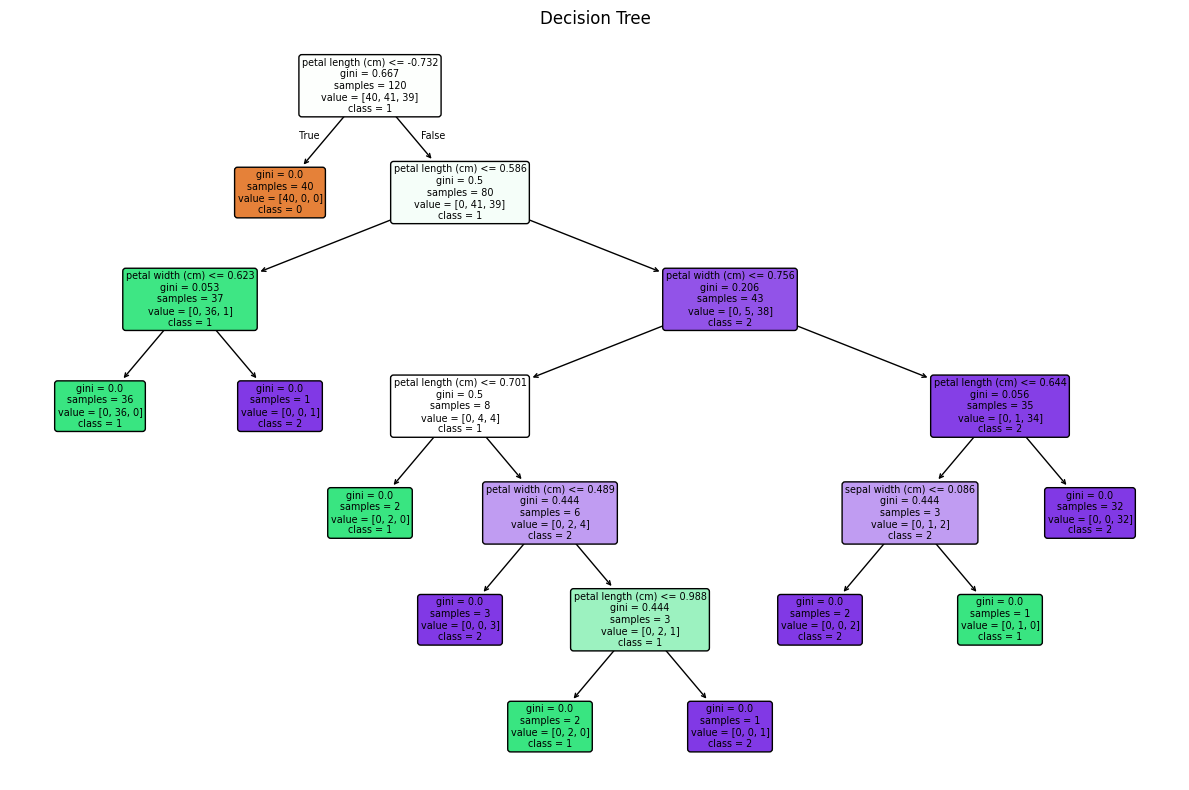

In [8]:
"""
Decision Tree model script
Options: use_iris, use_dummy, or provide a small custom dataset (in code)

Usage:
- Edit the variable `DATA_SOURCE` to one of: 'iris', 'dummy', 'custom'
- Run the script: python decision_tree_model.py

This script does:
- loads data (no CSV required)
- basic preprocessing (scaling, categorical encoding if needed)
- train/test split
- trains DecisionTreeClassifier
- evaluates (accuracy, classification report, confusion matrix, cross-val)
- optional GridSearchCV hyperparameter tuning
- saves trained model to disk (joblib)
- plots & saves the tree diagram (matplotlib)

"""

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_iris

# ------------------------
# USER CONFIG
# ------------------------
# Choose data source: 'iris', 'dummy', or 'custom'
DATA_SOURCE = 'iris'

# If 'custom', define the `custom_df` (pandas DataFrame) and `target_column` below
# --- Synthetic Sales Dataset (1000 rows) ---
np.random.seed(42)
n_records = 1000

company_types = ['Trader', 'End User', 'Contractor', 'Dealer']
product_categories = ['Shackle', 'Sling', 'Hook', 'Wire Rope', 'Chain', 'Pulley']
made_in_list = ['India', 'China', 'Germany', 'USA']
manufacturers = ['Usha Martin', 'Crosby', 'Sealinker', 'Ferreterro', 'Van Beest']

custom_df = pd.DataFrame({
    "Quote_Value": np.random.randint(2000, 100000, n_records),
    "Company_Type": np.random.choice(company_types, n_records),
    "Product_Category": np.random.choice(product_categories, n_records),
    "PO_Amount": np.random.randint(0, 100000, n_records),
    "Made_In": np.random.choice(made_in_list, n_records),
    "Manufacturer": np.random.choice(manufacturers, n_records)
})

# Synthetic rule for Order Success
def success_rule(row):
    score = 0
    if row['Quote_Value'] < 50000: score += 1
    if row['Company_Type'] in ['End User', 'Contractor']: score += 1
    if row['Manufacturer'] in ['Sealinker', 'Usha Martin']: score += 1
    if row['PO_Amount'] > 0: score += 1
    return 1 if score >= 2 else 0

custom_df['Order_Success'] = custom_df.apply(success_rule, axis=1)
target_column = 'Order_Success'

# Model & training settings
TEST_SIZE = 0.2
RANDOM_STATE = 42
PERFORM_GRID_SEARCH = True

# Grid search parameter grid (only used if PERFORM_GRID_SEARCH=True)
PARAM_GRID = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 3, 5, 7],
    'model__min_samples_split': [2, 4, 6]
}

# Output filenames
MODEL_OUT = 'decision_tree_model.joblib'
TREE_PLOT_OUT = 'decision_tree_plot.png'

# ------------------------
# Prepare dataset
# ------------------------
if DATA_SOURCE == 'iris':
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = pd.Series(iris.target, name='target')
    feature_names = X.columns.tolist()
    task_type = 'multiclass'

elif DATA_SOURCE == 'dummy':
    data = {
        'Age': [22, 25, 47, 52, 46, 56, 23, 34, 31, 29],
        'Income': [15000, 30000, 50000, 45000, 60000, 80000, 18000, 32000, 28000, 29000],
        'Buys': [0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
    }
    df = pd.DataFrame(data)
    X = df.drop('Buys', axis=1)
    y = df['Buys']
    feature_names = X.columns.tolist()
    task_type = 'binary'

elif DATA_SOURCE == 'custom':
    df = custom_df.copy()
    if target_column not in df.columns:
        raise ValueError(f"target_column '{target_column}' not found in custom_df")
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    feature_names = X.columns.tolist()
    # crude guess for task type
    task_type = 'binary' if y.nunique() == 2 else 'multiclass' if y.nunique() > 2 else 'regression'

else:
    raise ValueError("Unsupported DATA_SOURCE. Choose from 'iris','dummy','custom'.")

print(f"Data source: {DATA_SOURCE}")
print(f"Features: {feature_names}")
print(f"Target classes: {np.unique(y)}")

# ------------------------
# Preprocessing pipeline
# ------------------------
# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

transformers = []
if num_cols:
    transformers.append(('num', StandardScaler(), num_cols))
if cat_cols:
    transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols))

if transformers:
    preprocessor = ColumnTransformer(transformers=transformers)
else:
    preprocessor = 'passthrough'

# Build pipeline with preprocessor + decision tree
pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# ------------------------
# Train / Test split
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# ------------------------
# Optional: Grid Search
# ------------------------
if PERFORM_GRID_SEARCH:
    gs = GridSearchCV(pipeline, PARAM_GRID, cv=5, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train, y_train)
    print("Best params:", gs.best_params_)
    best_model = gs.best_estimator_
else:
    pipeline.fit(X_train, y_train)
    best_model = pipeline

# ------------------------
# Evaluation
# ------------------------
# Predict
y_pred = best_model.predict(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-validation score on full data (simple check)
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"5-fold CV accuracy: mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}")

# ------------------------
# Save the trained model
# ------------------------
joblib.dump(best_model, MODEL_OUT)
print(f"Saved trained model to {MODEL_OUT}")

# ------------------------
# Plot & save decision tree
# ------------------------
# Extract the tree from the pipeline
# If using pipeline with 'pre' and 'model', the final estimator is at named_steps['model']
final_estimator = best_model.named_steps['model'] if hasattr(best_model, 'named_steps') else best_model

# Fit a simple pipeline on the entire dataset (for plotting feature names after preprocessing)
# We will try to get a transformed feature names list if OneHotEncoder was used
fitted_preprocessor = None
if hasattr(best_model, 'named_steps') and best_model.named_steps.get('pre') != 'passthrough':
    fitted_preprocessor = best_model.named_steps['pre']

# Try to build a human-readable feature list after preprocessing
try:
    if fitted_preprocessor is not None and hasattr(fitted_preprocessor, 'transformers_'):
        out_features = []
        for name, trans, cols in fitted_preprocessor.transformers_:
            if name == 'num':
                out_features.extend(cols)
            elif name == 'cat':
                # onehot encoder: get feature names
                ohe = trans
                if hasattr(ohe, 'get_feature_names_out'):
                    out_features.extend(ohe.get_feature_names_out(cols))
                else:
                    # fallback
                    for c in cols:
                        out_features.append(c)
    else:
        out_features = feature_names
except Exception:
    out_features = feature_names

plt.figure(figsize=(12, 8))
plot_tree(final_estimator, feature_names=out_features, class_names=[str(c) for c in np.unique(y)], filled=True, rounded=True)
plt.title('Decision Tree')
plt.tight_layout()
plt.savefig(TREE_PLOT_OUT, dpi=150)
print(f"Saved tree plot to {TREE_PLOT_OUT}")

# ------------------------
# End
# ------------------------
print('Done')
